# Rossman Store Sales Prediction

## IMPORTS

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
import datetime
from pandas.api.types import is_string_dtype, is_numeric_dtype

from IPython.core.display import HTML
from IPython.display import Image

# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())


Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.1


### Helper Functions

### Loading Data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# Merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how = 'left', on = 'Store' )

In [3]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## DATA DISCRIPTION

### Rename Columns

In [4]:
#Copy dataset
df1 = df_raw.copy()

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )

#Rename Columns

df1.columns = cols_new

In [6]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### Data Dimension

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


### Data Types

In [8]:
#Change datatype of column data to datetime
df1['date'] = pd.to_datetime( df1[ 'date' ] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

### Check NA values

In [10]:
#Checking NA values sum
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [11]:
missing_count = df1.isnull().sum() # the count of missing values
value_count = df1.isnull().count() # the count of all values

missing_percentage = round(missing_count/value_count *100, 2) # the percentage of missing values
missing_df = pd.DataFrame({'missing values count': missing_count, 'percentage': missing_percentage})
missing_df

,missing values count,percentage
store,0,0.00
day_of_week,0,0.00
date,0,0.00
sales,0,0.00
customers,0,0.00
open,0,0.00
promo,0,0.00
state_holiday,0,0.00
school_holiday,0,0.00
store_type,0,0.00


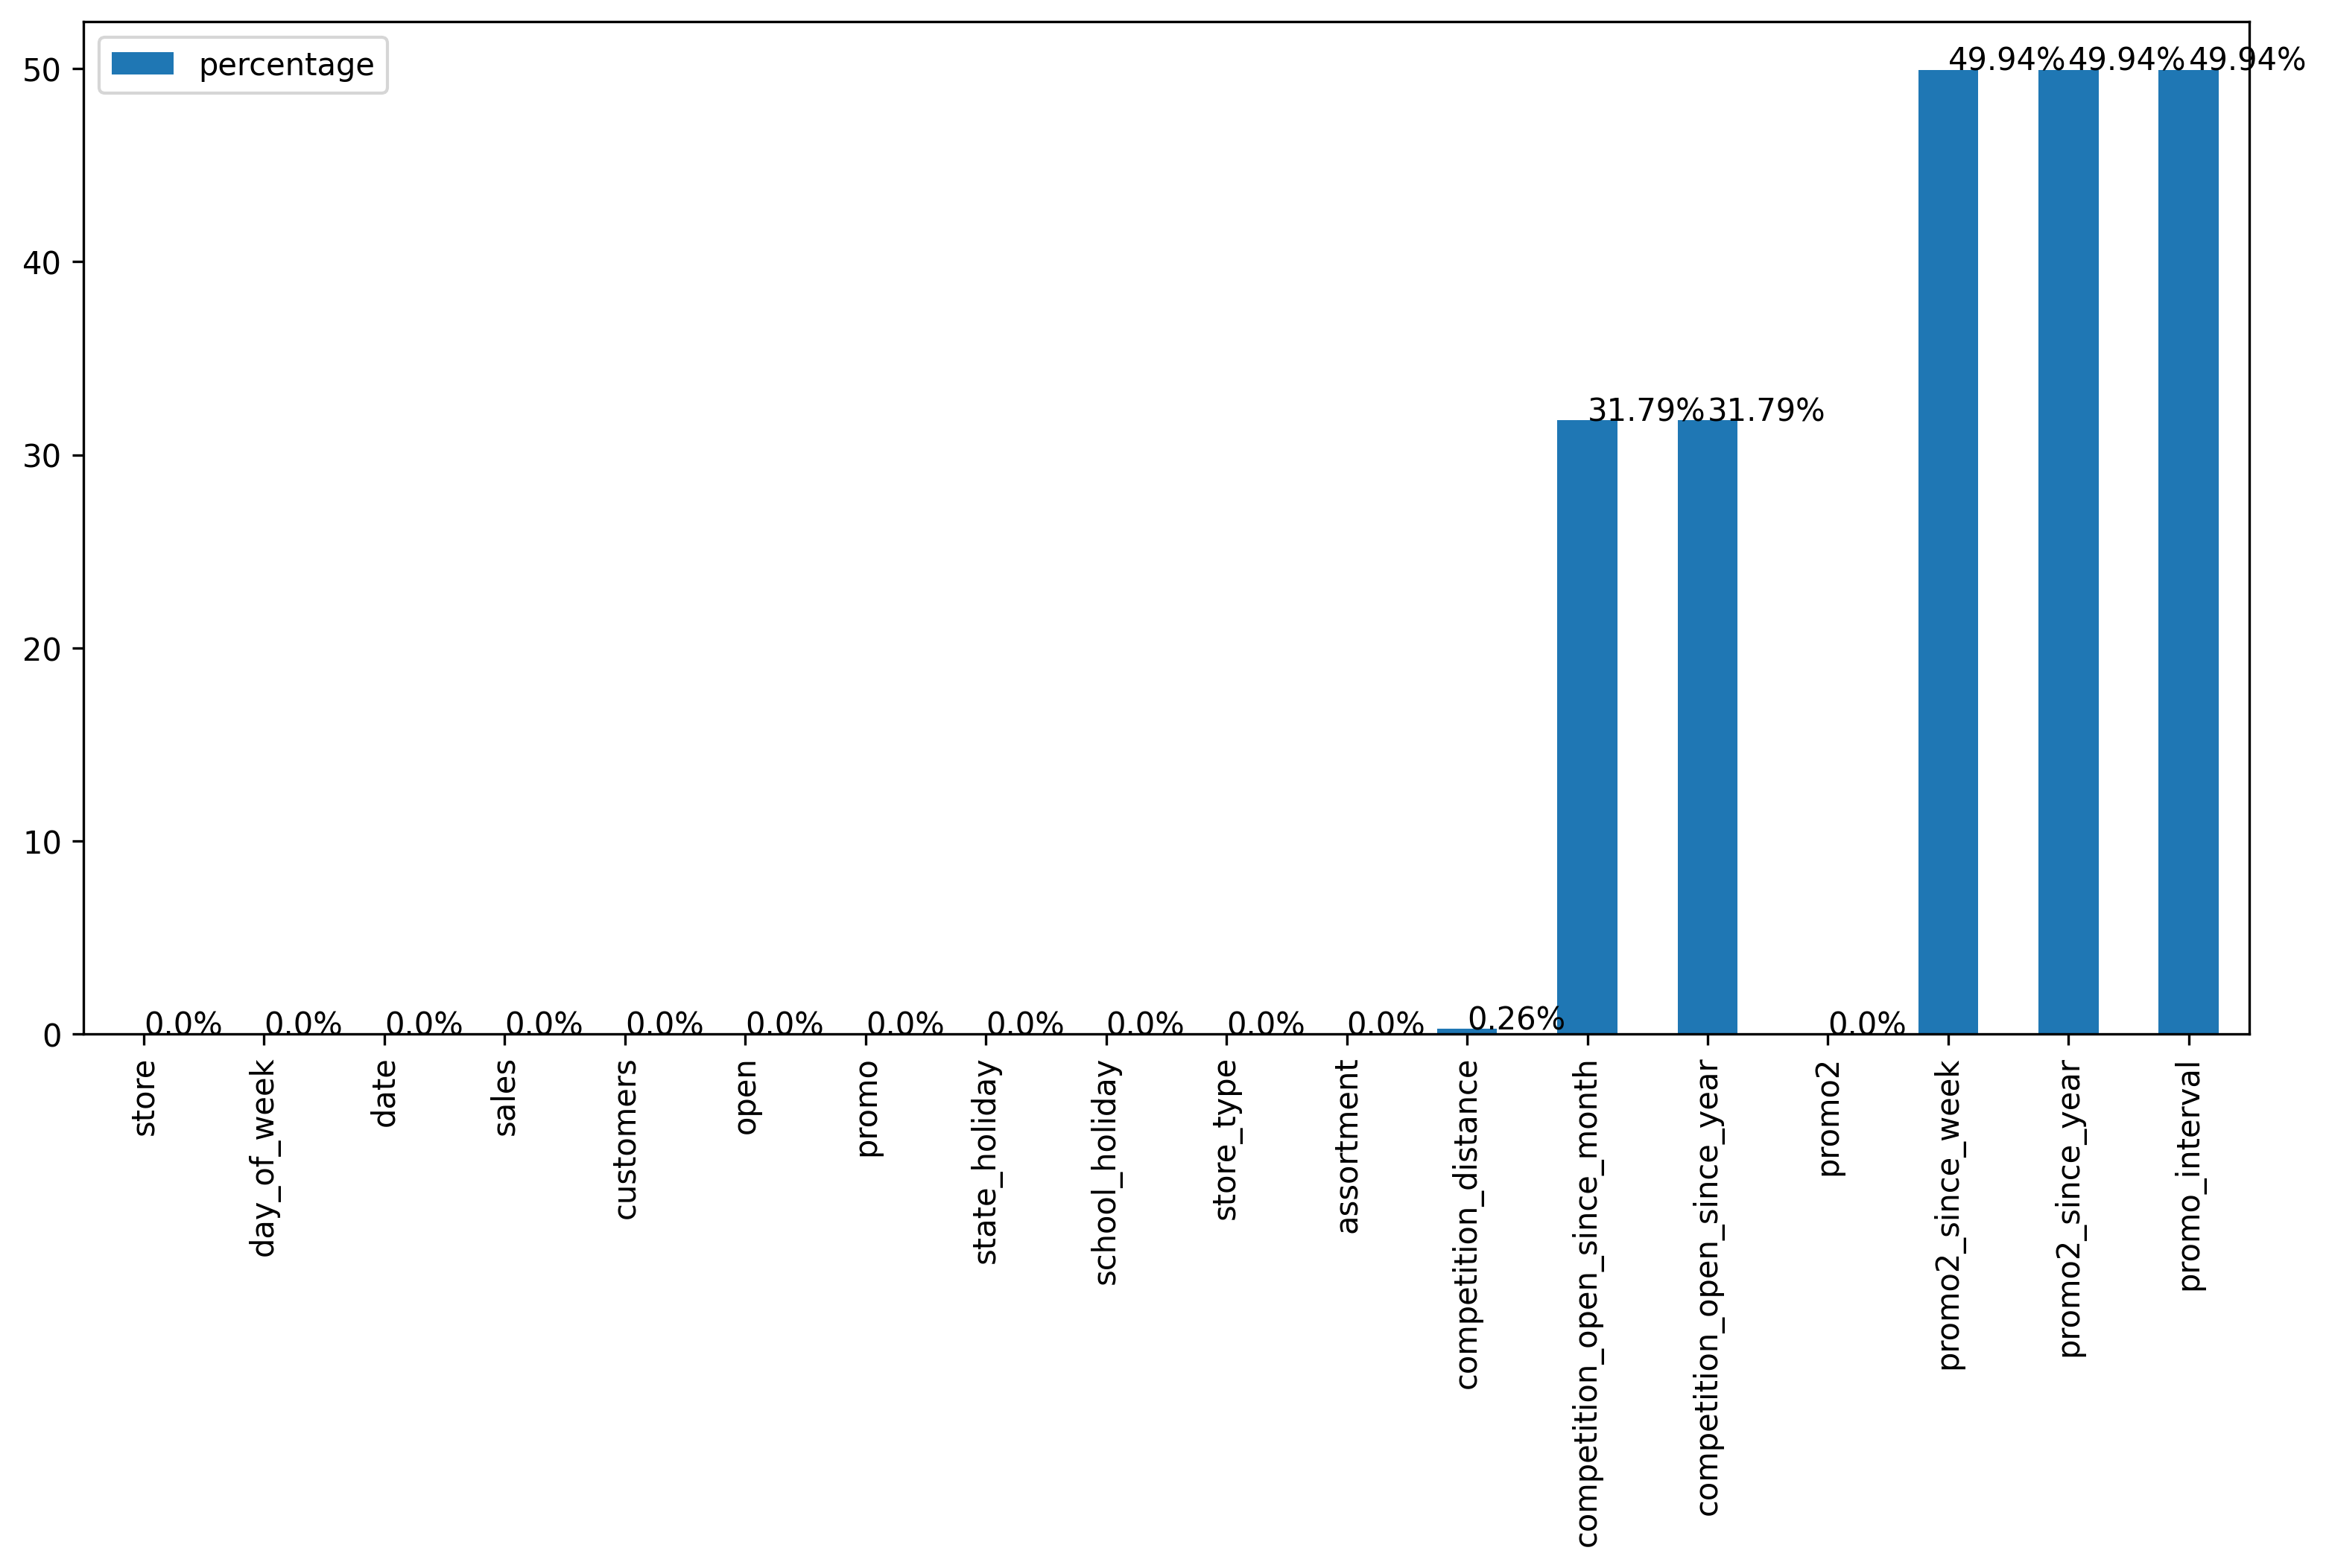

In [12]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [12.5, 6]

barchart = missing_df.plot.bar(y='percentage')
for index, percentage in enumerate( missing_percentage ):
    barchart.text( index, percentage, str(percentage)+'%')

In [13]:
df1['store'].duplicated().value_counts()

True     1016094
False       1115
Name: store, dtype: int64

### Fillout NA

In [14]:
# competition_distance              2642
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month    323348
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'],
                                               axis = 1 )
# competition_open_since_year     323348
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'],
                                               axis = 1 )
# promo2_since_week               508031
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'],
                                               axis = 1 )
# promo2_since_year               508031
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'],
                                               axis = 1 )
# promo_interval                  508031
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5:'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna( 0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo'] = df1[[ 'promo_interval', 'month_map' ]].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### Change Types

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### Descriptive Statistics

In [18]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


In [19]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'])
cate_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])

In [20]:
num_list = []
cat_list = []

for column in df1:
    if is_numeric_dtype(df1[column]):
        num_list.append(column)
    elif is_string_dtype(df1[column]):
        cat_list.append(column)
        
print(num_list)

print(cat_list)

['store', 'day_of_week', 'sales', 'customers', 'open', 'promo', 'school_holiday', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'is_promo']
['state_holiday', 'store_type', 'assortment', 'promo_interval', 'month_map']


#### Numerical Attributes

In [21]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


#### Categorical Attributes

In [22]:
cate_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

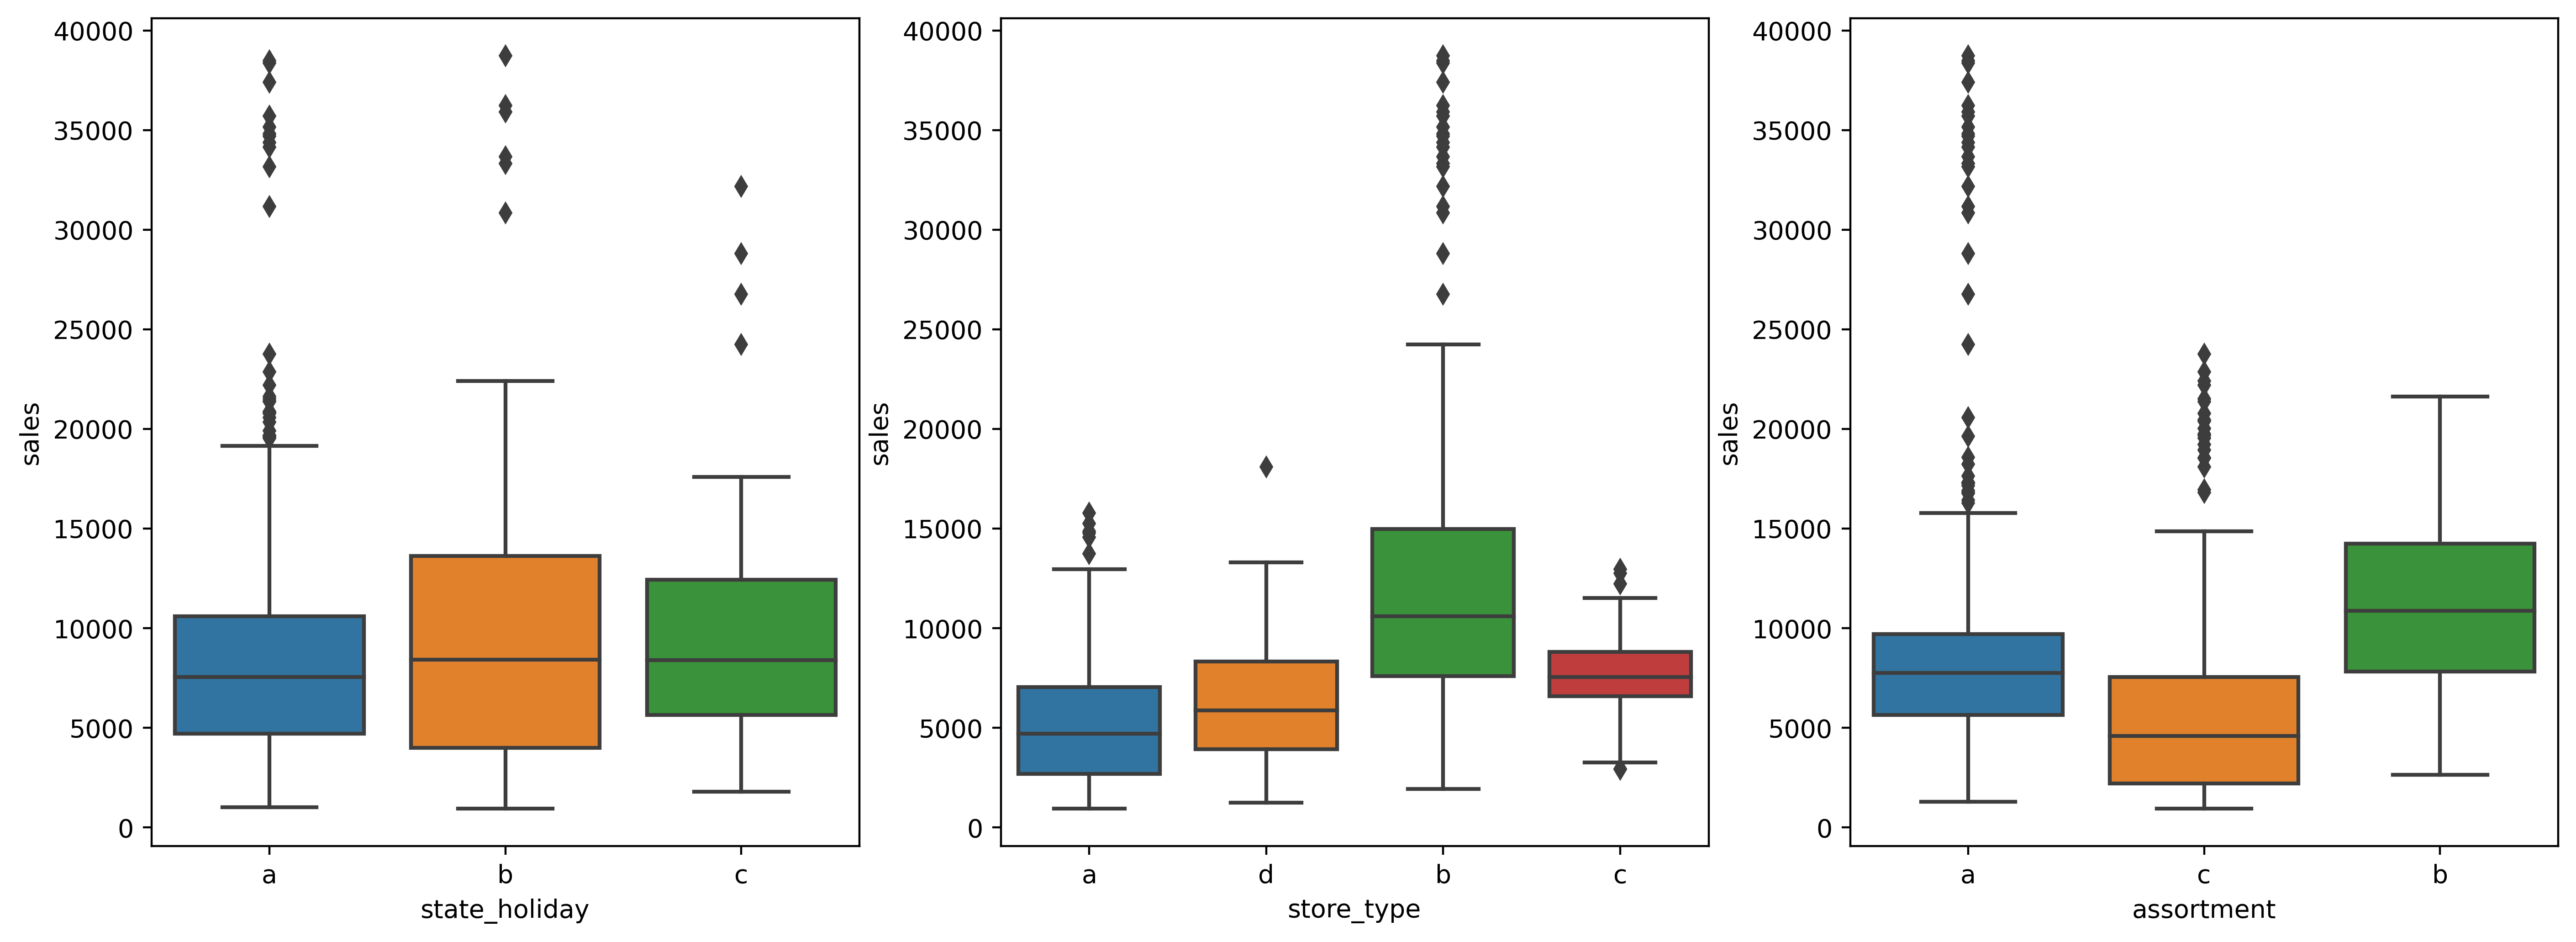

In [23]:
plt.rcParams['figure.dpi'] = 400
plt.rcParams['figure.figsize'] = [17, 6]

aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot (1, 3, 1)
sns.boxplot(x='state_holiday', y= 'sales', data=aux1)

plt.subplot (1, 3, 2)
sns.boxplot(x='store_type', y= 'sales', data=aux1)

plt.subplot (1, 3, 3)
sns.boxplot(x='assortment', y= 'sales', data=aux1)

## FEATURE ENGINEERING

In [108]:
df2 = df1.copy()

### Hypothesis Mindmap

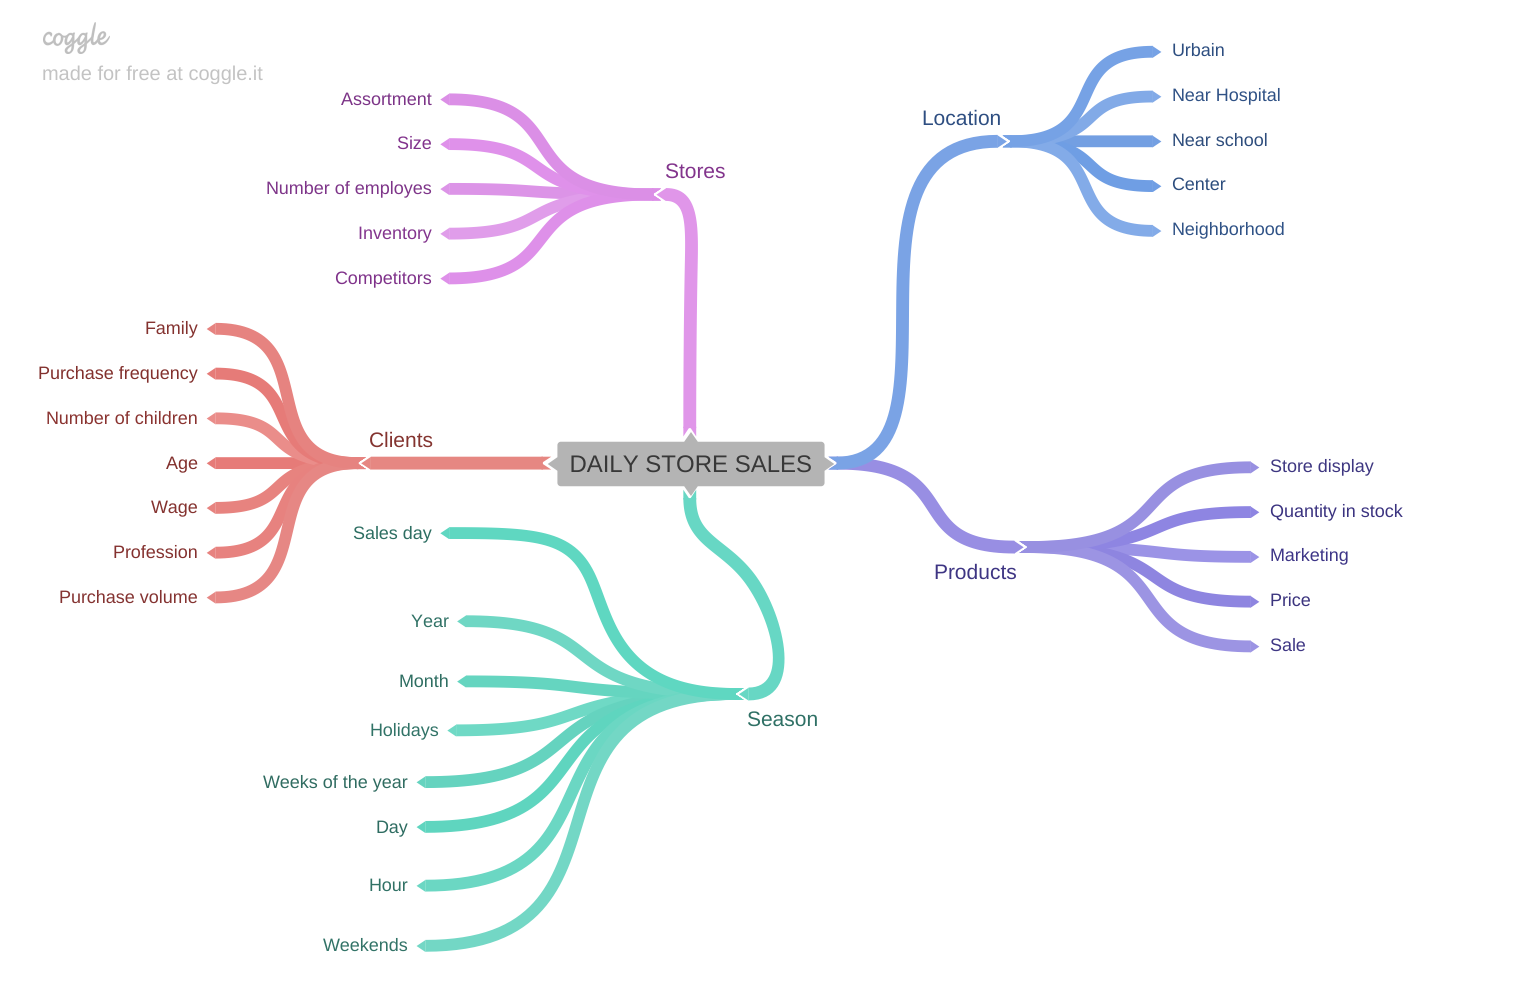

In [25]:
Image('img/DAILY_STORE_SALES_HYPOTESES.png')

### Creating Hypothesis

#### Store Hypothesis

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

#### Product Hypothesis

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

#### Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### Final Hypothesis List

In [40]:
# Priorização baseado nos atributos disponíveis no dataset

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


### Feature Engineering

In [26]:
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo'],
      dtype='object')

In [110]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since (month and year)
df2['competition_since'] = df2[['competition_open_since_year', 'competition_open_since_month']].apply(lambda x: 
                                                                                                      datetime.datetime( year = x['competition_open_since_year'], 
                                                                                                                        month = x['competition_open_since_month'], 
                                                                                                             day=1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

# # promo since
# df2['promo_since'] = str(df2['promo2_since_year']) + '-' +str(df2['promo2_since_week'])
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else
                                         'extra' if x == 'b' else
                                         'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else
                                               'easter_holiday' if x == 'b' else
                                               'Christmas' if x == 'c' else
                                               'regular_day')

In [111]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## VARIABLE FILTERING 

In [113]:
df3 = df2.copy()

In [114]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


### Line Filtering

In [116]:
df3 = df3[(df3['open'] != 0) & (df3['sales']> 0)]

### Columns Selection

In [117]:
cols_drop = ['customers', 'open','promo_interval', 'month_map']
df3.drop(cols_drop, axis = 1)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,basic,150.0,...,0,2013,1,1,1,2013-00,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,extra,860.0,...,0,2013,1,1,1,2013-00,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,extra,840.0,...,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,extra,1430.0,...,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


## EXPLORATORY DATA ANALYSIS (EDA)

In [118]:
df4 = df3.copy()

### Univariate Analysis

#### Response Variable

C:\Users\marxv\anaconda3\envs\Kaggle-Rossman-Sales-Prediction\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

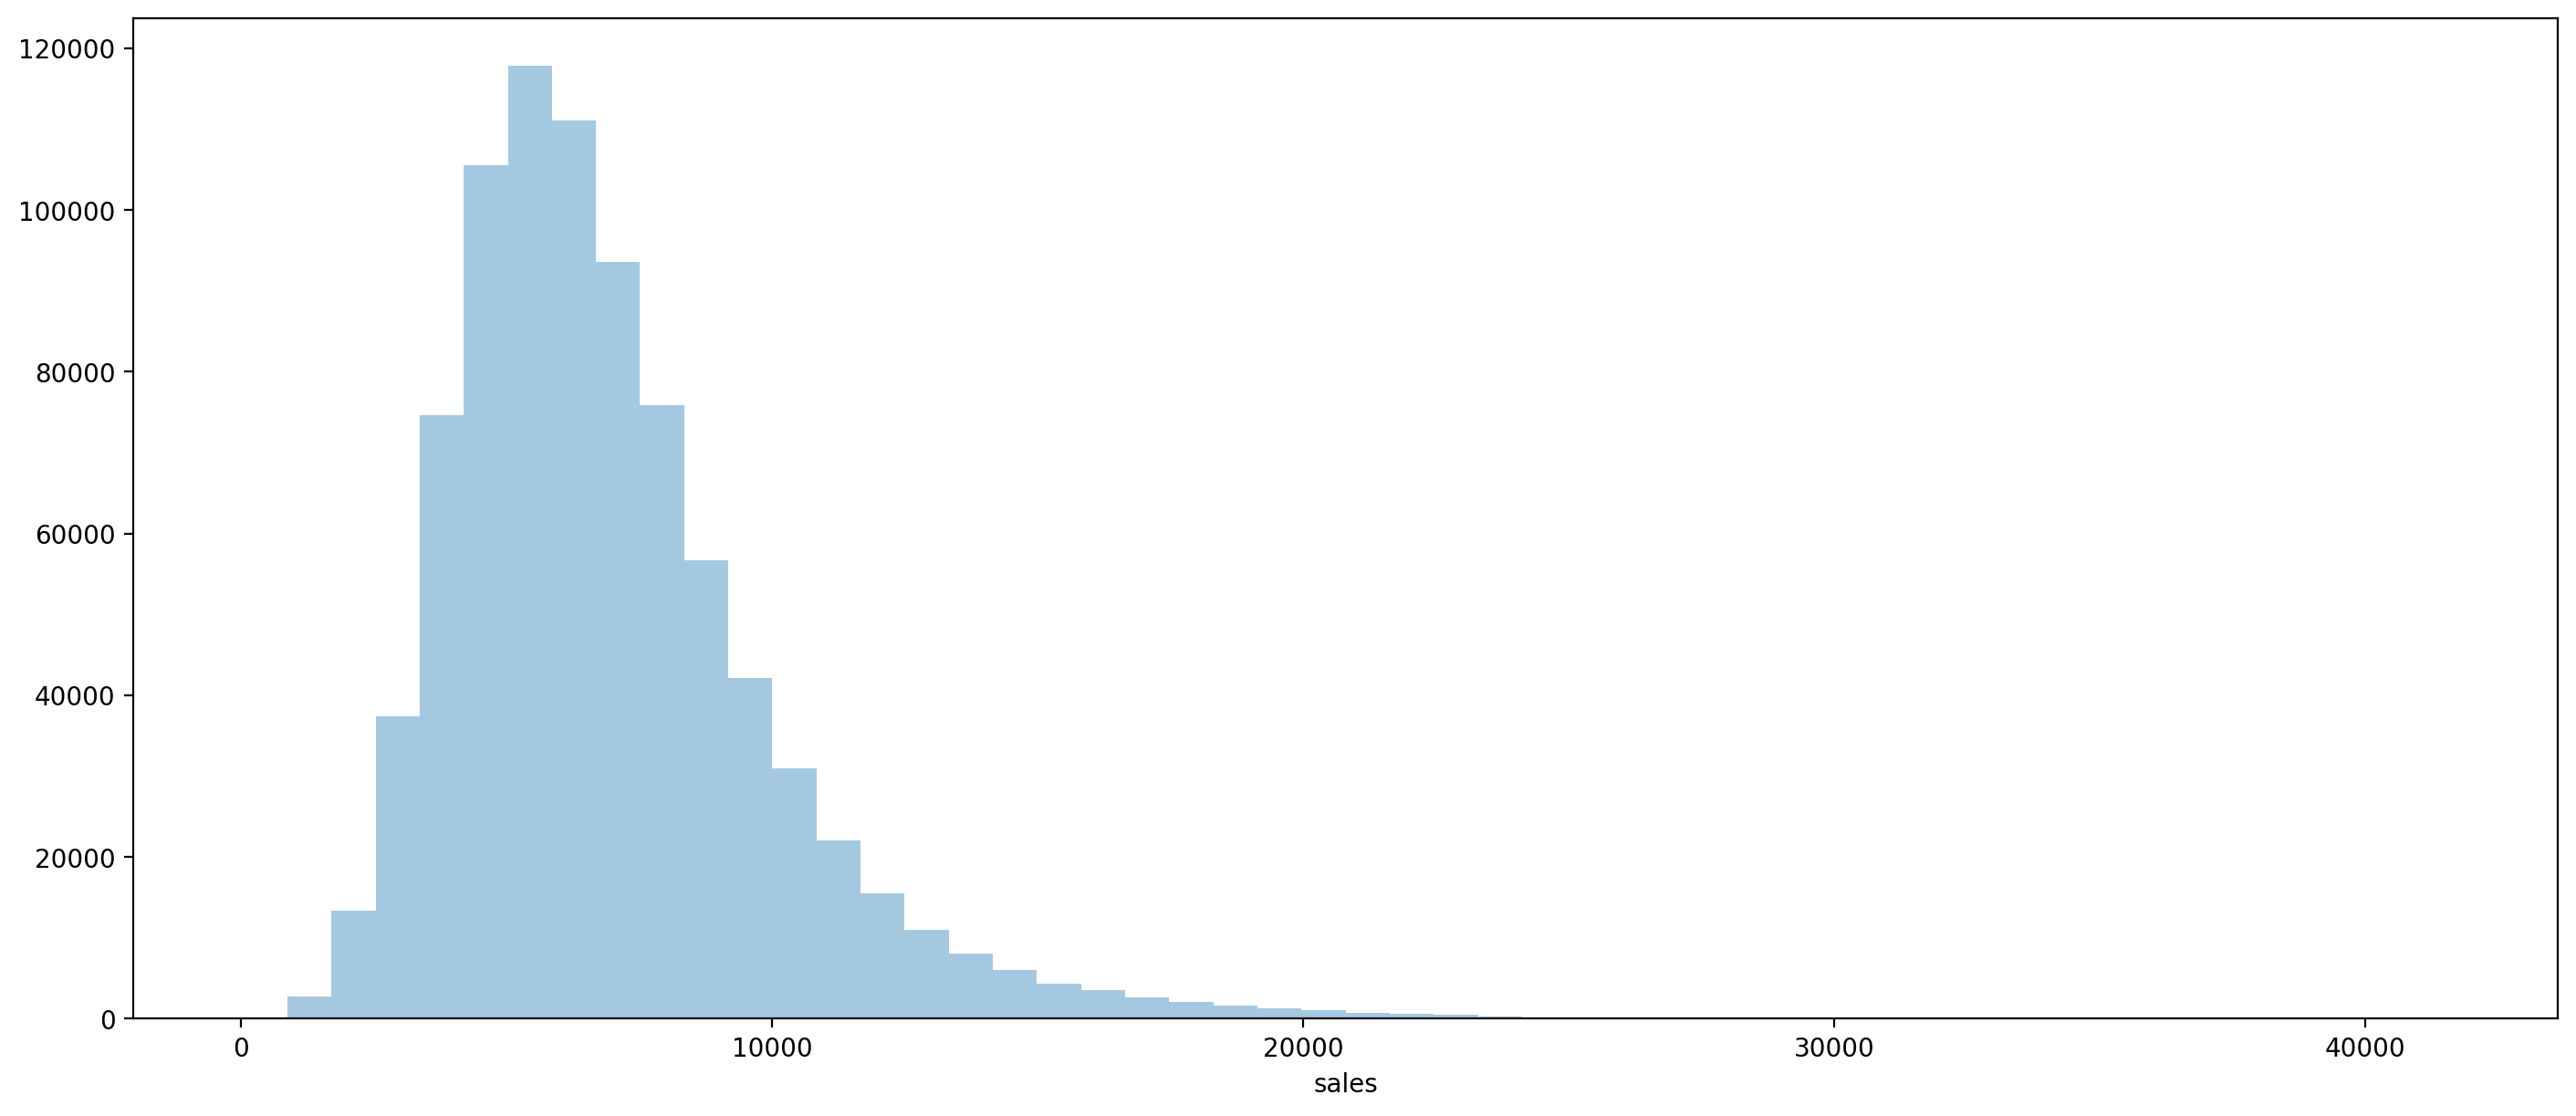

In [123]:
fig = plt.figure( figsize = (14, 6), constrained_layout=True)
sns.distplot(df4['sales'], kde = False)

#### Numerical Variable

<Figure size 2800x1200 with 0 Axes>

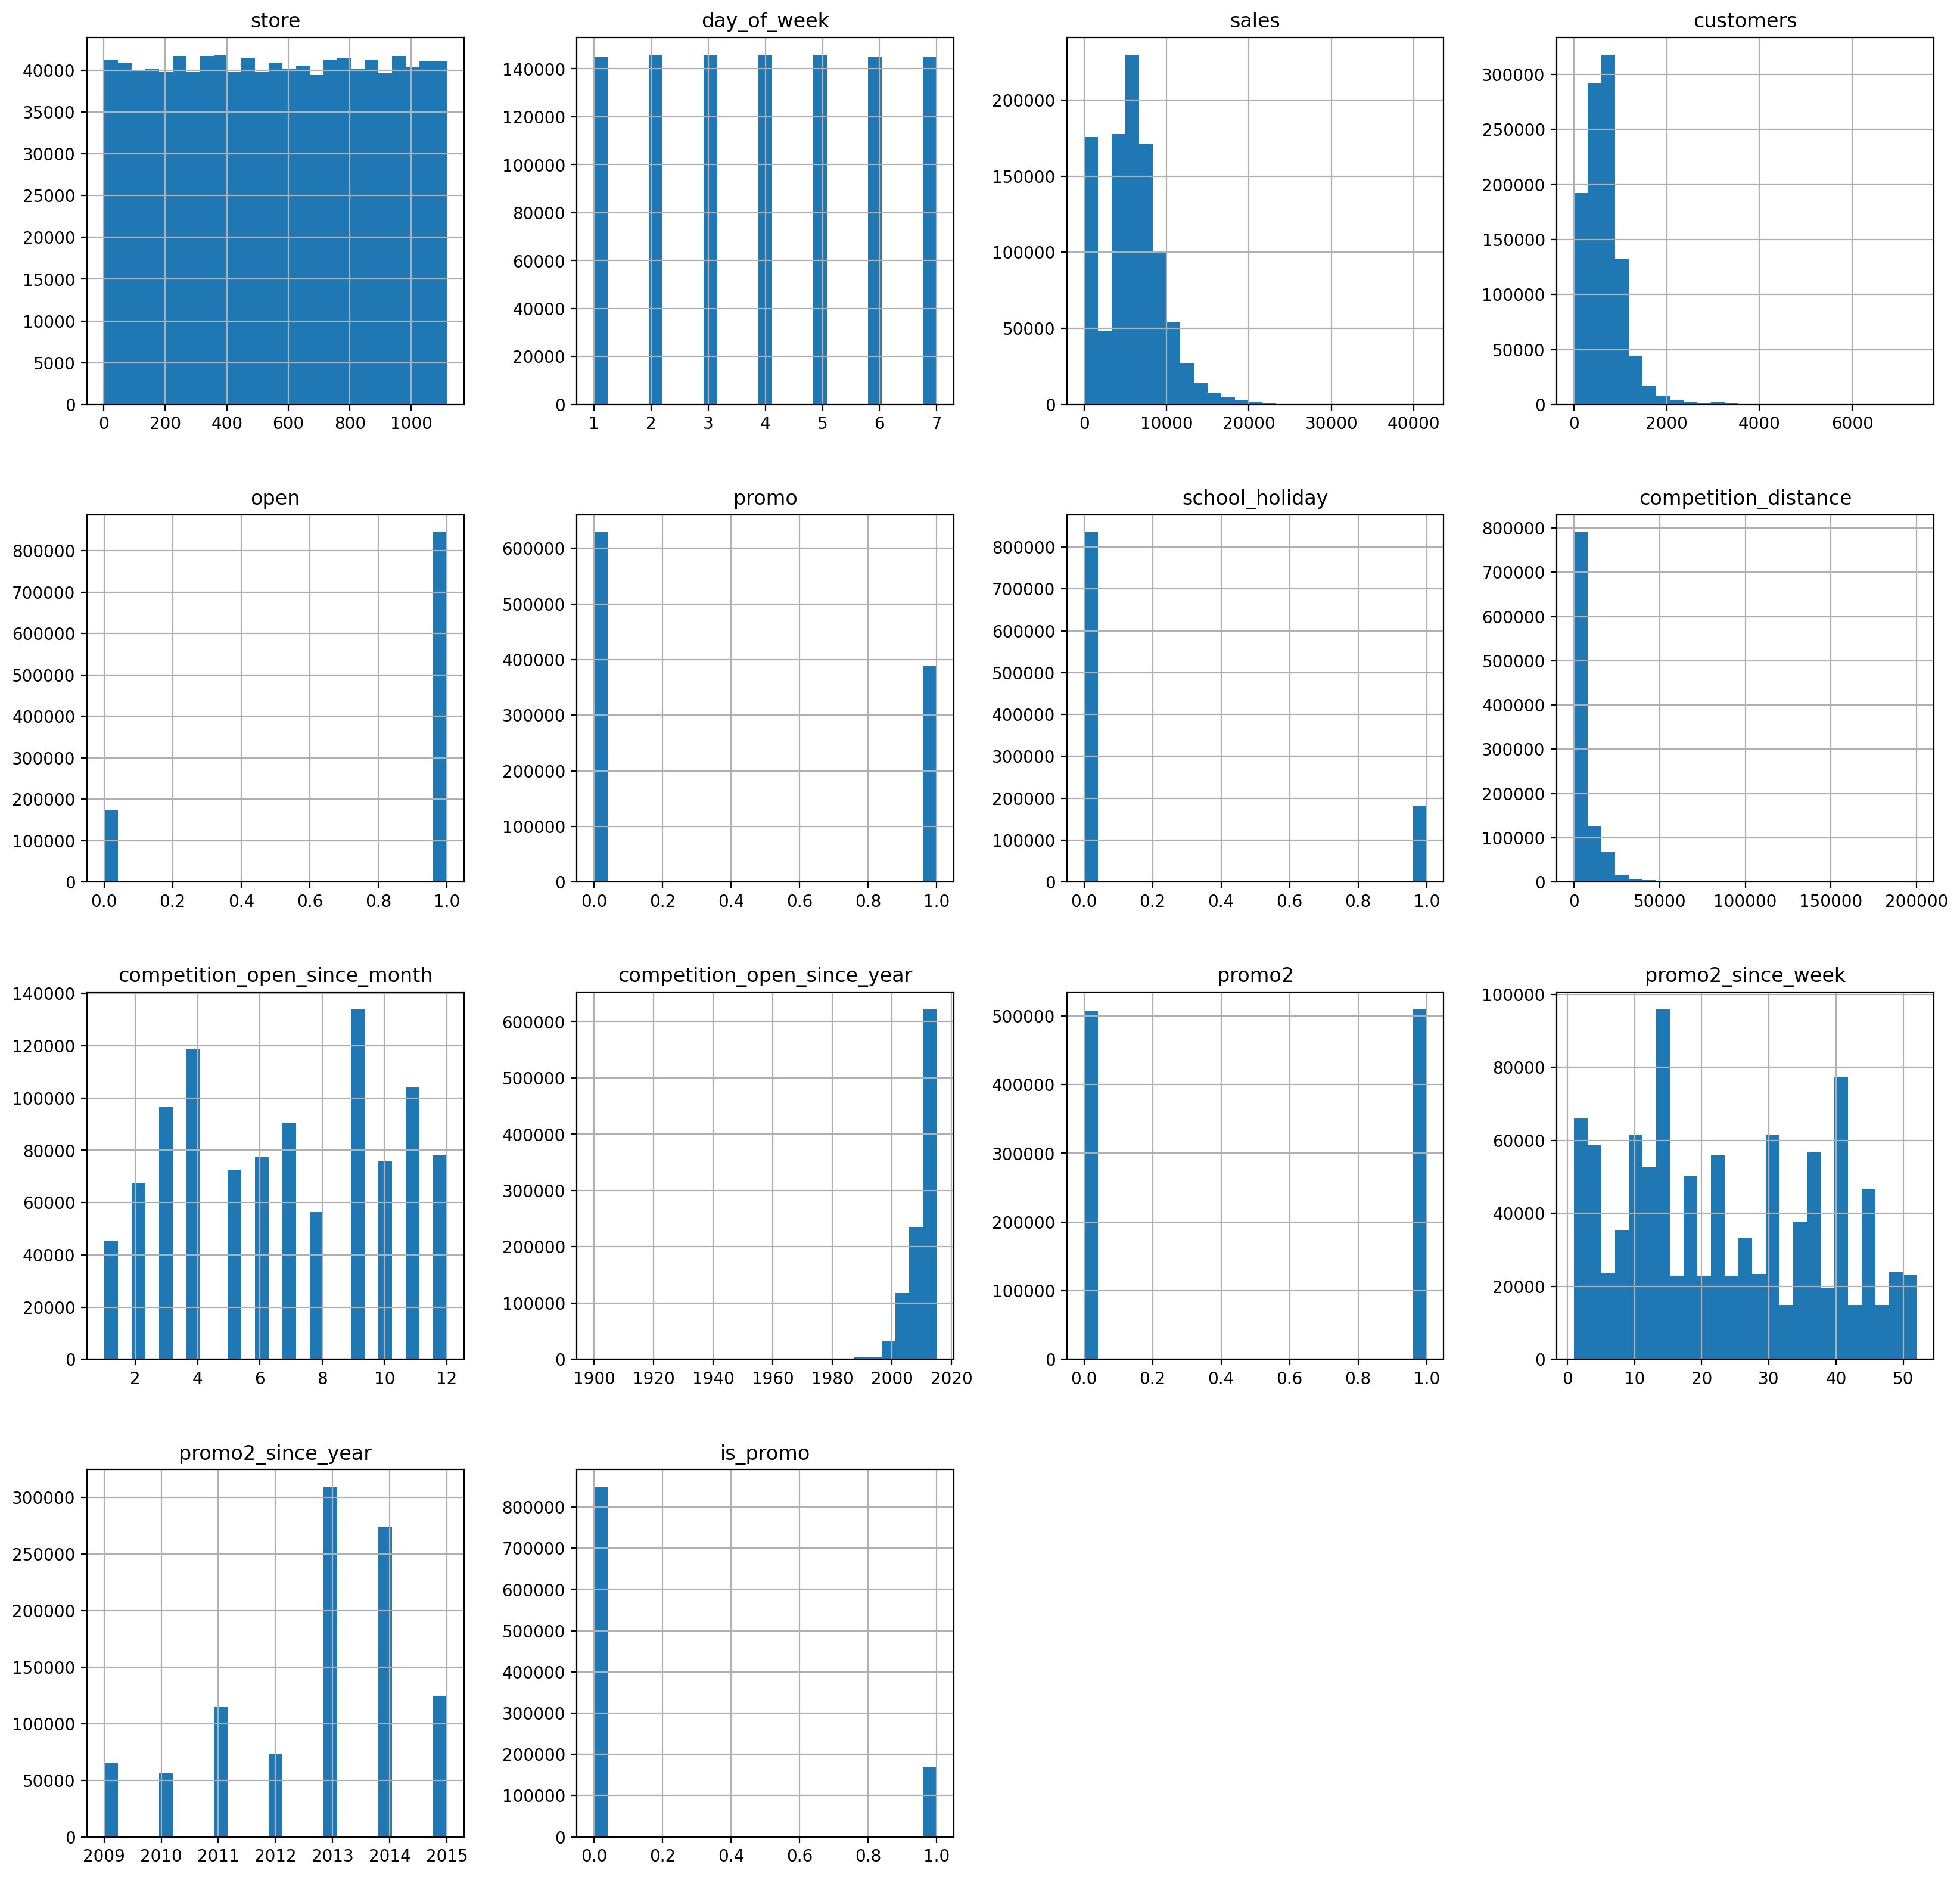

In [121]:
fig = plt.figure( figsize = (14, 6), constrained_layout=True)
num_attributes.hist(bins = 25);

#### Categorical Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

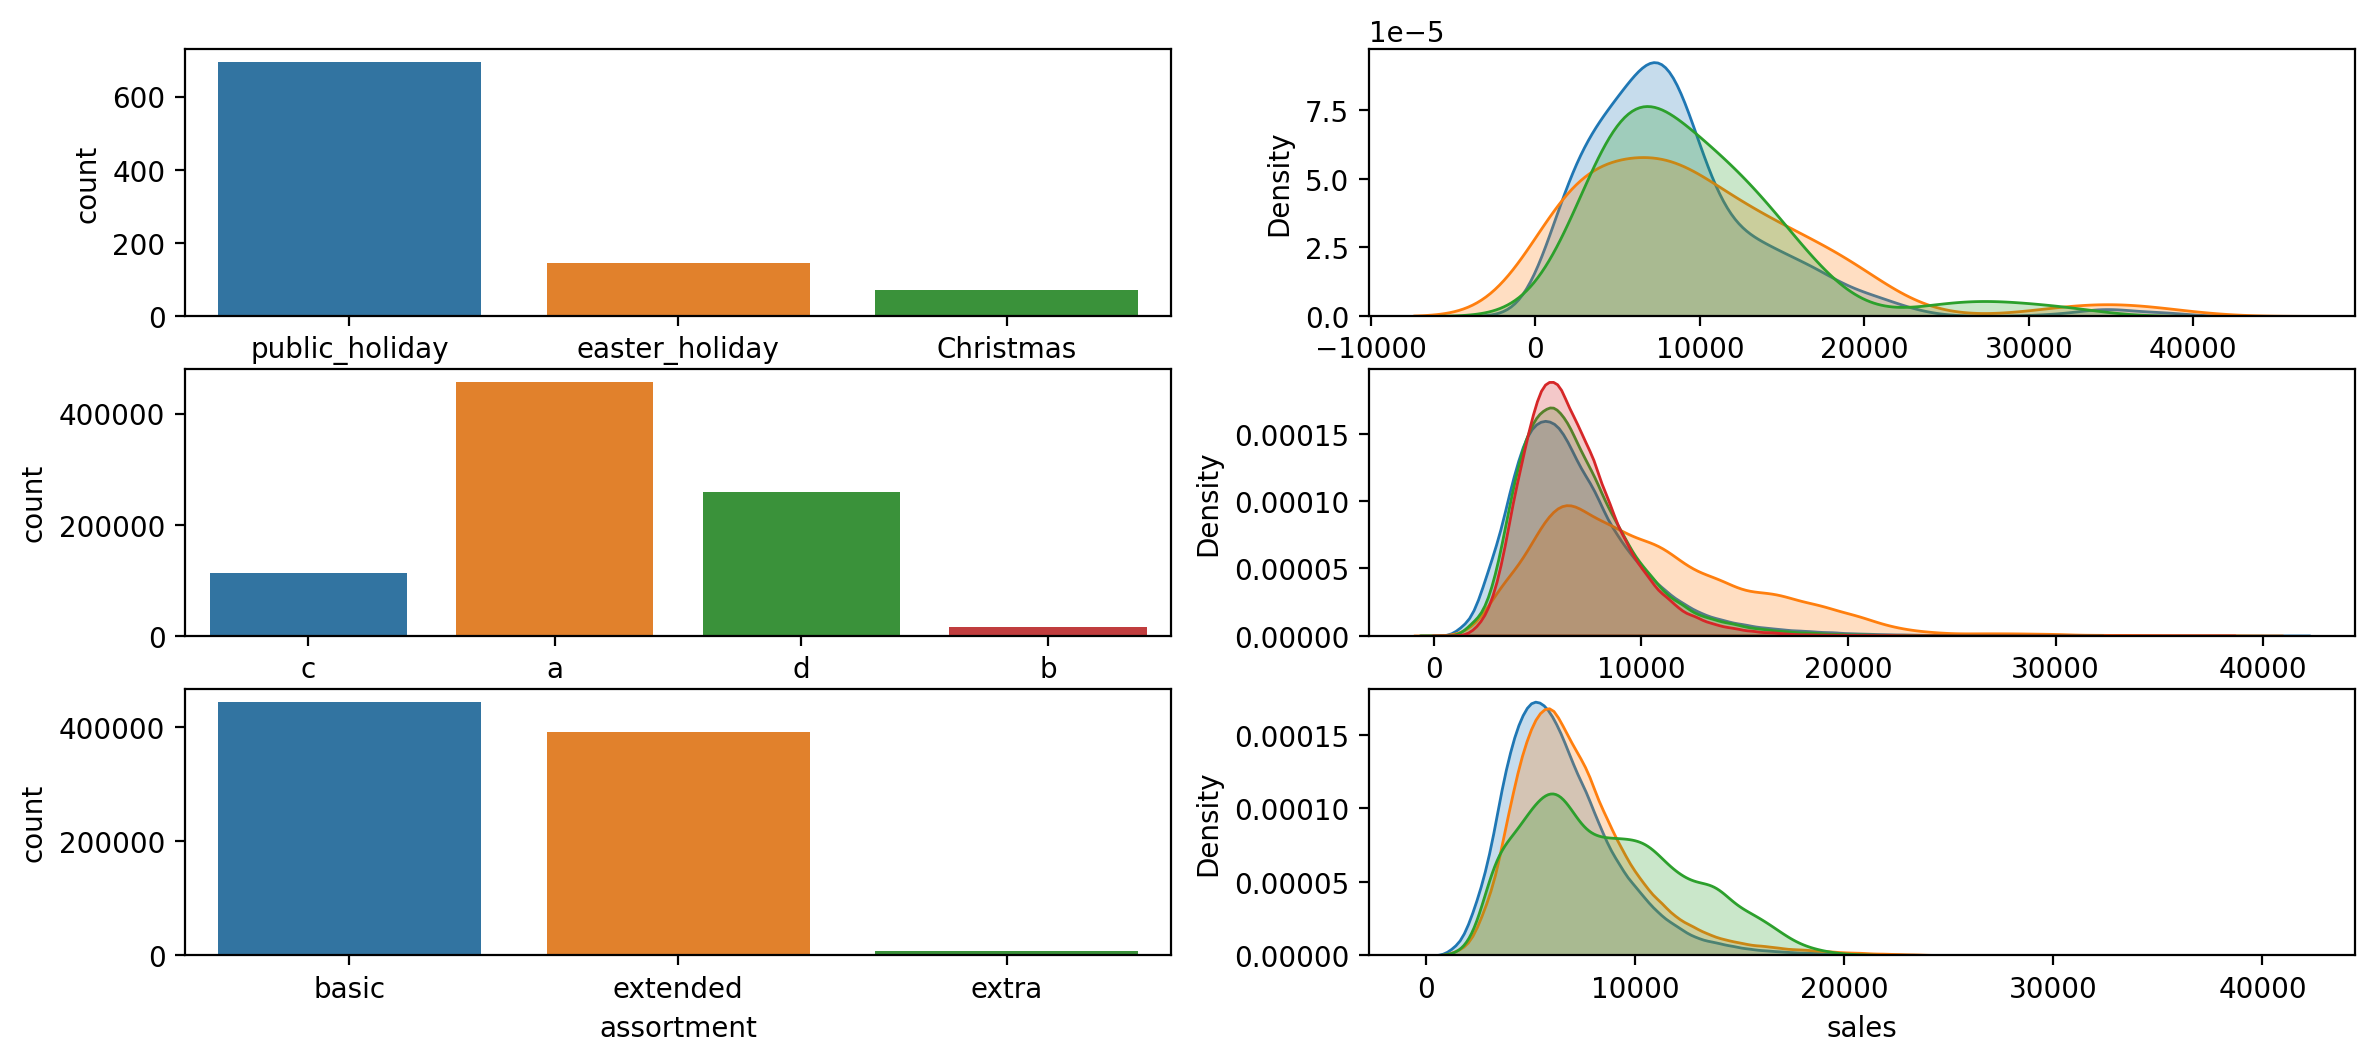

In [177]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data = a, x = a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(data = df4, x = df4[df4['state_holiday'] == 'public_holiday']['sales'], shade=True )
sns.kdeplot(data = df4, x = df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(data = df4, x = df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', shade=True )

# store_type
plt.subplot(3, 2, 3)
sns.countplot(data = df4, x = df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(data = df4, x = df4[df4['store_type'] == 'a']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['store_type'] == 'b']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['store_type'] == 'c']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['store_type'] == 'd']['sales'], shade = True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(data = df4, x = df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(data = df4, x = df4[df4['assortment'] == 'basic']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['assortment'] == 'extended']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['assortment'] == 'extra']['sales'], shade = True)

### Bivariate Analysis

#### H1. Lojas com maior sortimentos deveriam vender mais.



<AxesSubplot:xlabel='assortment', ylabel='sales'>

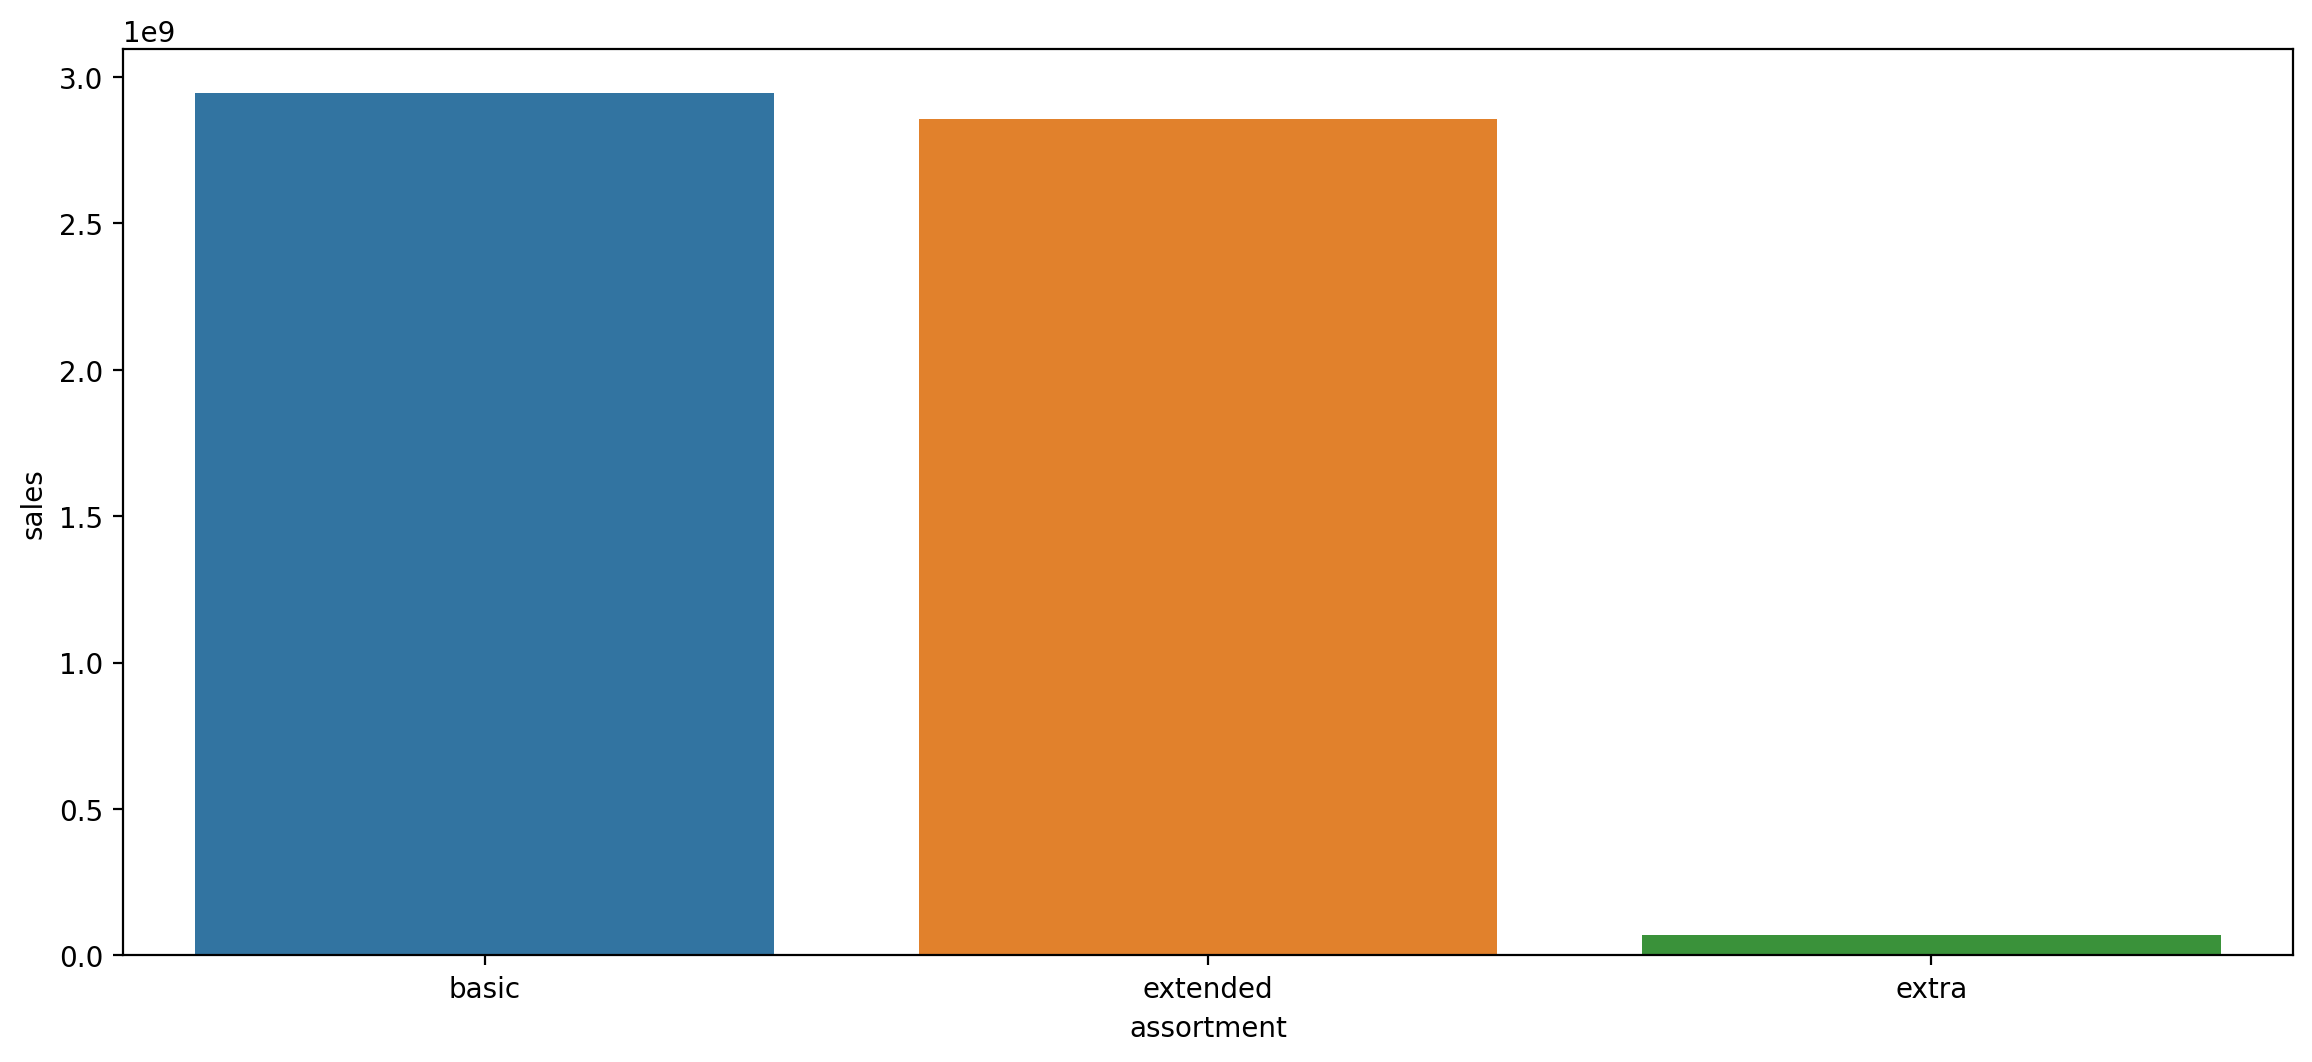

In [181]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1)

#### H2. Lojas com competidores mais próximos deveriam vender menos.



#### H3. Lojas com competidores à mais tempo deveriam vendem mais.

### Multivariate Analysis